# Supervised Learning final project
## Language detection based on speech samples

### Goal and description of the dataset

In this project, I am using speech data for Indian languages and trying to classify the majority language in an audio file.
I am using this dataset of speech samples for Indian languages.  
https://www.kaggle.com/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages

This dataset includes small samples of speech data in 10 different indian languages that are under 5 seconds in length each that are labeled based on the majority language in each of the samples.
I am going to use a subset of this data to train some supervised learning models to distinguish speech of Hindi and Urdu which are two very closely related Indian languages.

The goal of this task is to create a classifier which can do language detection based on audio (speech) data.

Github link for this project https://github.com/bharath1097/csca5622_project

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import librosa
import pandas as pd
%matplotlib inline

The data is organized as 5 second mp3 files under folders named after each language.
The below code plots the signals of a couple of samples one in Hindi and one in Urdu and provides a play button to play the audio.

The length of the audio sample is 5.0050 seconds.
Hindi speech sample sampling_rate = 22050, audio_ts.shape = (110360,)


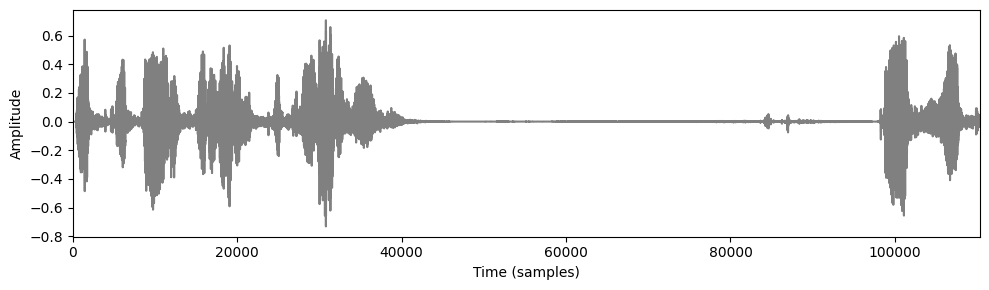

The length of the audio sample is 4.9810 seconds.
Urdu speech sample sampling_rate = 22050, audio_ts.shape = (109831,)


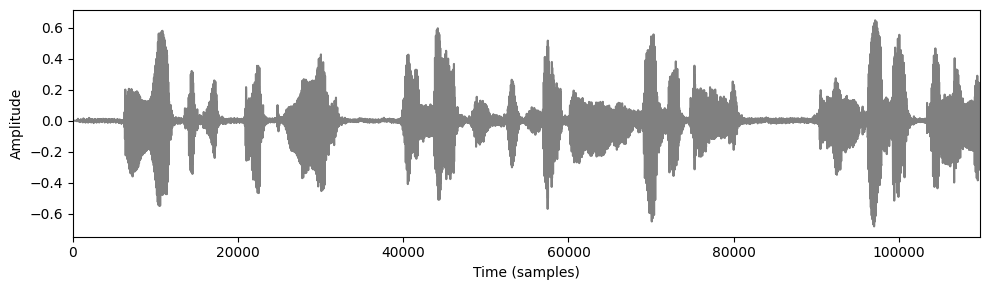

In [5]:
def display_player(audio_ts, sampling_rate, text=''):
    """Plots a waveform of the audio time series and presents a player to play it.
    Parameters
    ----------
    audio_ts: np.ndarray
        audio time series
    sampling_rate: number
        sampling rate of the signal
    text: str
        Custom text to display above the player
    """
    print(f'{text} sampling_rate = {sampling_rate}, audio_ts.shape = {audio_ts.shape}')
    
    plt.figure(figsize=(10, 3))
    
    plt.plot(audio_ts, color='gray')
    plt.xlim([0, audio_ts.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=audio_ts, rate=sampling_rate))

hindi_audio, sr = librosa.load('data/Hindi/10001.mp3')
print(f'The length of the audio sample is {len(hindi_audio) / sr:.4f} seconds.')
display_player(hindi_audio, sr, 'Hindi speech sample')

urdu_audio, sr = librosa.load('data/Urdu/10001.mp3')
print(f'The length of the audio sample is {len(urdu_audio) / sr:.4f} seconds.')
display_player(urdu_audio, sr, 'Urdu speech sample')

In [23]:

hindi_audio_files = librosa.util.find_files('data/Hindi')
print(f'There are {len(hindi_audio_files)} hindi speech samples')

urdu_audio_files = librosa.util.find_files('data/Urdu')
print(f'There are {len(urdu_audio_files)} urdu speech samples')


There are 25462 hindi speech samples
There are 31960 urdu speech samples


### Data Cleanup

We have around 25000+ Hindi and 30000+ Urdu speech samples in the dataset.

I am going to filter bad samples out of this dataset as my next step.  My approach here is to try to open the audio files and filter out any files that don't open or are too small.

Also I calculate a feature called spectral flatness. Spectral flatness indicates how much like white noise the sound signal is. We get a spectral flatness of close to 1.0 for files that are either completely silent or files with less tones and more white noise. I am also going to filter these files out.

In [24]:
%%time

def filter_audio_files(file_list, threshold=0.5):
    """
    Filters out bad speech samples from the file_list

    Parameters
    ----------
    file_list: list of str
        List of audio files
    threshold: float
        Any audio samples with spectral_flatness above this threshold are filtered out

    Returns
    -------
    A generator of good audio samples
    """
    bad_files = []
    good_files = []
    for audio_file in file_list:
        try:
            audio_ts, sr = librosa.load(audio_file)
            audio_ts = librosa.util.normalize(audio_ts)
        except ValueError:
            continue
        if len(audio_ts) < 20000:
            continue
        spectral_flatness = librosa.feature.spectral_flatness(y=audio_ts, n_fft=512)
        if np.mean(spectral_flatness) > threshold:
            continue
        yield audio_file

hindi_audio_files = list(filter_audio_files(hindi_audio_files))
print(f'There are {len(hindi_audio_files)} usable Hindi speech samples')

urdu_audio_files = list(filter_audio_files(urdu_audio_files))
print(f'There are {len(urdu_audio_files)} usable Urdu speech samples')

There are 25157 usable Hindi speech samples


<timed exec>:20: UserWarning: PySoundFile failed. Trying audioread instead.
/root/.virtualenvs/supervised_learning/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


There are 31759 usable Urdu speech samples
CPU times: user 9min 2s, sys: 13.3 s, total: 9min 15s
Wall time: 9min 18s


I filtered out 25157 usable speech samples out of 25462 speech samples available in the dataset for Hindi and I filtered out 31759 usable speech samples out of 31960 available in the Urdu dataset.


### EDA and Feature extraction

We need to extract some features from the audio files that we can use to train the classifier.  
Below are plots showing how the audio signal looks like in time and frequency domain.

Time-domain signal sampling_rate = 22050, audio_ts.shape = (109752,)


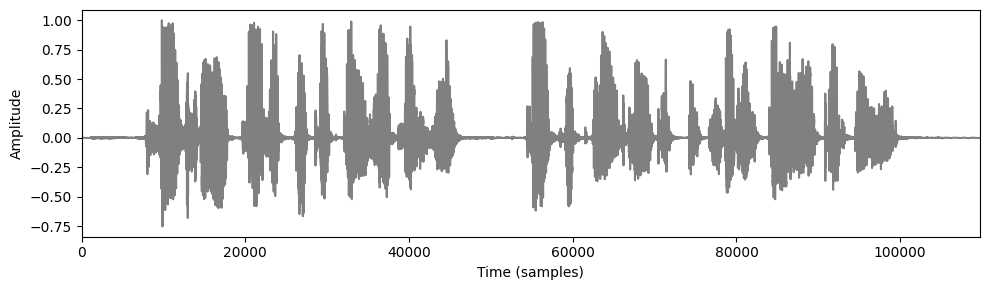

In [41]:
audio_ts, sr = librosa.load(hindi_audio_files[0])
audio_ts = librosa.util.normalize(audio_ts)
display_player(audio_ts, sr, 'Time-domain signal')

Text(0, 0.5, 'Power')

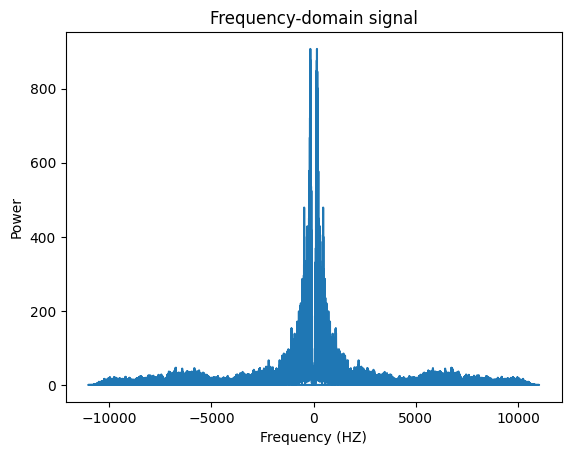

In [43]:
from scipy.fft import fft, fftfreq
yf = fft(audio_ts)
xf = fftfreq(len(audio_ts), 1 / sr)
plt.plot(xf, np.abs(yf))

plt.title("Frequency-domain signal")
plt.xlabel("Frequency (HZ)")
plt.ylabel("Power")


Ideally to know the characteristics of an audio signal, we would want both time and frequency domain features. Short-term fourier transform is a way to represent a signal in both time and frequency domains at the same time.
Below I have calculated the short-term fourier transform for the above audio file and plotted it using a spectrogram.

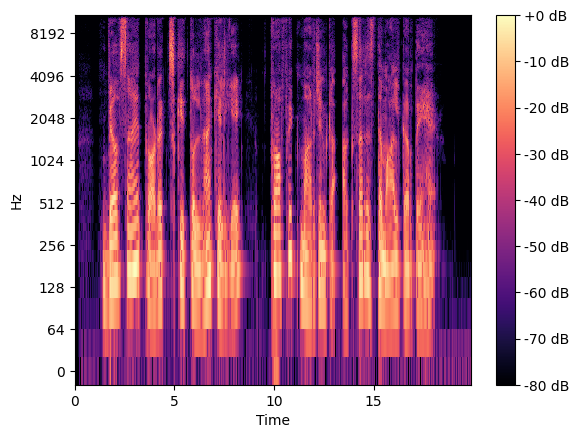

In [46]:
# Calculate the short term fourier transform
stft = librosa.stft(audio_ts, n_fft=512)
# Convert the amplitude/power into log scale (dB)
stft_dB = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
librosa.display.specshow(stft_dB, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

Humans perceive frequency/pitch changes in log scale rather than on a linear scale (similiar to how we perceive amplitude of a sound signal too).  
So there is an alternative scale for frequency called mel-scale which is related to the regular frequency scale by the formula  
$m = 2595\times log_{10}(1 + f/700)$
where m is in mel-scale and f is the frequence in HZ.
A mel-scale spectrogram is more indicative of how we hear the characteristics of a sound signal.
Below is the mel-spectrogram for the sample speech signal

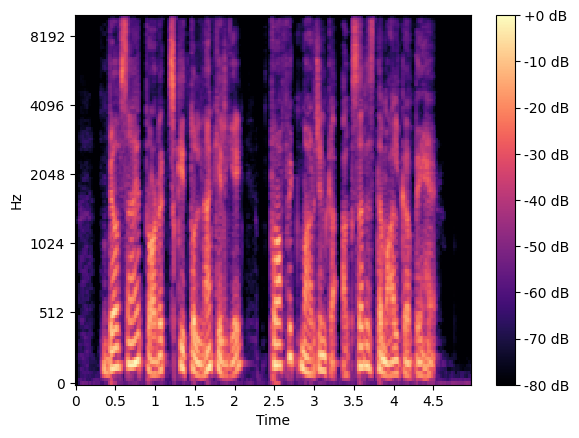

In [49]:
# Computing a mel-spectrogram
mel_s = librosa.feature.melspectrogram(y=audio_ts, sr=sr)
mel_s_dB = librosa.power_to_db(mel_s, ref=np.max)
librosa.display.specshow(mel_s_dB, x_axis='time', y_axis='mel', sr=sr, fmax=10000)
plt.colorbar(format='%+2.0f dB')


If we take a discrete cosine transform of the mel-spectrogram we end up with a set of coefficients called MFCCs (Mel Frequency Cepstral Coefficients). These coefficients are able to isolate the features of human speech very well.
For example, they separate the phonemes and timbre in human speech from the pitch and other characteristics. So these are some of the most useful features we can use to train any model for human speech processing.
I am going to extract the MFCCs from the audio signal and use them as features for training the classifiers.

In [53]:
# This divides the audio signal into frames of size 512 samples each with overlap and
# calculates the first 40 mfcc coefficients for each of the frames.
mfccs = librosa.feature.mfcc(y=audio_ts, sr=sr, n_mfcc=40, n_fft=512, hop_length=256)
print(mfccs.shape)
print(mfccs)

# mfccs would be a matrix with shape (num_coefficients, num_frames)

(40, 429)
[[-6.72378174e+02 -6.72378174e+02 -6.72378174e+02 ... -6.63710449e+02
  -6.63416992e+02 -6.61697021e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.22241411e+01
   1.25502224e+01  1.50579567e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.21228895e+01
   1.22168293e+01  1.49161987e+01]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.13722587e+00
   2.30555356e-01  5.27848840e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.13494158e+00
   3.86913776e-01  5.91713905e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.13531041e+00
   5.23927987e-01  6.49408460e-01]]


I am going to extract the first 40 mfccs for each of the audio files.
I will end up with a (40, num_frames) matrix for mfccs for each audio file.
I am going to flatten it by taking a the mean of each coefficient across all frames in a file and end up with a feature vector of size 40 one for each coefficient.

In [27]:
def extract_features(audio_files):
    feature_matrix = []
    for audio_file in audio_files:
        audio_ts, sr = librosa.load(audio_file)
        audio_ts = librosa.util.normalize(audio_ts)
        mfccs = librosa.feature.mfcc(y=audio_ts, sr=sr, n_mfcc=40, n_fft=512, hop_length=256)
        feature_vector = np.mean(mfccs, axis=1)
        feature_matrix.append(feature_vector)
    return feature_matrix

hindi_features = extract_features(hindi_audio_files)
urdu_features = extract_features(urdu_audio_files)
X = np.array(hindi_features + urdu_features)
print(X.shape)

# We'll use True to represent Urdu and False to represent Hindi
hindi_labels = [False] * len(hindi_audio_files)
urdu_labels = [True] * len(urdu_audio_files)
y = np.array(hindi_labels + urdu_labels)
print(y.shape)

    

(56916, 40)
(56916,)


Now we prepare the train and test datasets

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42687, 40)
(42687,)
(14229, 40)
(14229,)


Below I am plotting a correlation matrix to see which of the mfcc coefficients are most correlated with the language of the speech signal.

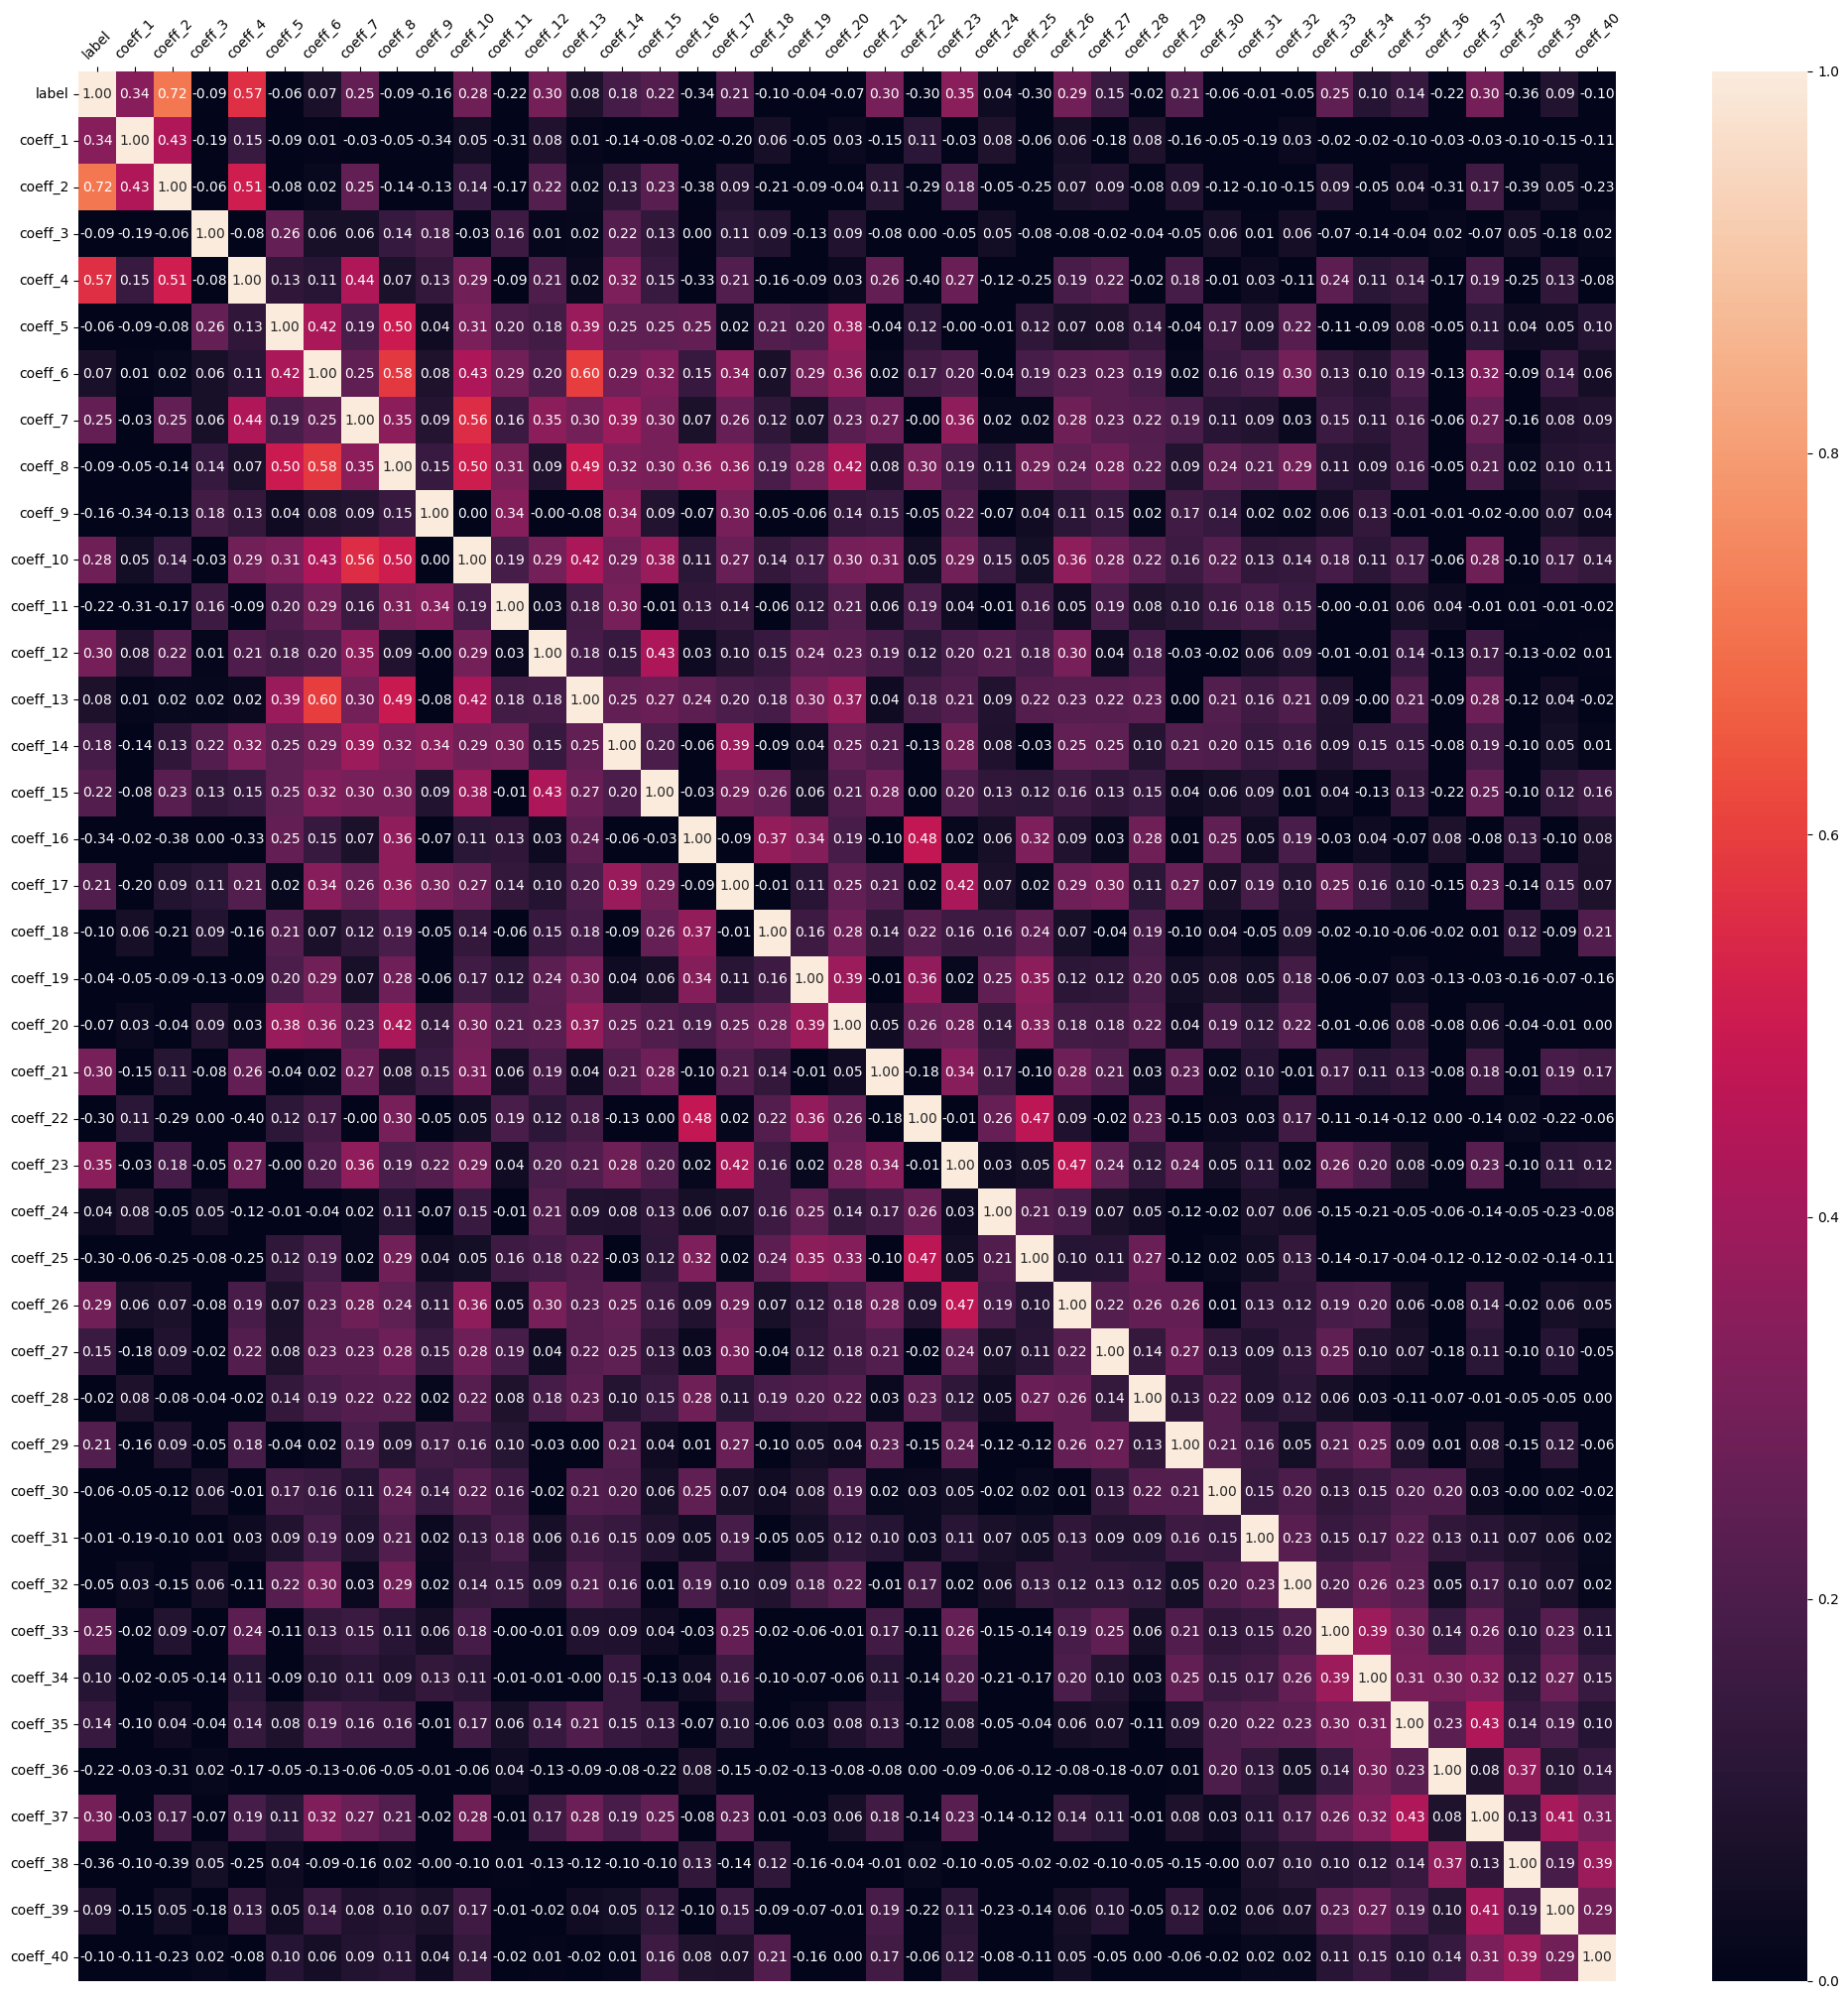

In [63]:
import seaborn as sns
col_names = [f'coeff_{i}' for i in range(1, 41)]
df = pd.DataFrame(X, columns=col_names)
df.insert(0, 'label', y)
plt.figure(figsize=(25, 25))
ax = sns.heatmap(df.corr(), annot=True, fmt='.2f', vmin=0.0, vmax=1.0)
ax.xaxis.tick_top()
ax.tick_params(axis='x', labelrotation=45)

The first few coefficients especially coeffs 1, 2 and 4 seems to be highly correlated with the language label.

### Classification Models


I am starting with a simple logistic regression model. I am going to use accuracy_score as the metric to evaluate the models as the classes are fairly balanced.

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LogReg = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X_train, y_train)
y_pred = LogReg.predict(X_test)
print(f'Accuracy for logistic regression model is {accuracy_score(y_test, y_pred):.4f}')

Accuracy for logistic regression model is 0.9664


The logistic regression model did show really good accuracy of 0.9664 in distinguishing Hindi and Urdu over the test data. 

In [66]:
print(LogReg.coef_)

[[ 0.02918784  0.09587412  0.03727013  0.06792843  0.036285   -0.06574578
  -0.04981335 -0.02758118 -0.22703113  0.14893911 -0.06355442  0.07909949
   0.02860627 -0.00264464 -0.10767191 -0.2780388   0.12338942  0.09115317
   0.15796604 -0.3680825   0.36526785  0.07511178  0.3762366   0.23324201
  -0.29049228  0.35486567  0.15749842  0.03987691  0.32798077 -0.08223556
   0.00146048  0.14431325  0.41122335 -0.1383872   0.13814177  0.11897589
   0.57304599 -0.77795506 -0.06552855 -0.19581458]]


I am going to try Decision tree classifiers and both parallel and sequential ensemble methods like RandomForest and GradientBoosting to see whether I can further improve the accuracy
of the classification.

In [68]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced').fit(X_train, y_train)
print(f'Accuracy for decision tree classifier is {dt.score(X_test, y_test):.4f}')


Accuracy for decision tree classifier is 0.9814


We got a pretty impressive accuracy of 0.9814 on the test data using a decision tree classifier. I am going to see whether the ensemble methods can improve it further.

In [69]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)
print(f'Accuracy for random forest classifier is {clf.score(X_test, y_test):.4f}')

Accuracy for random forest classifier is 0.9973


We got an even more impressive 0.9973 accuracy with a random forest classifier.

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier().fit(X_train, y_train)
print(f'Accuracy for gradient boost classifier is {clf.score(X_test, y_test):.4f}')

Accuracy for gradient boost classifier is 0.9944


Now checking to see if we can tune the hyperparameters of the ensemble models to see if we can further improve the accuracy.

In [82]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), parameters, cv=3, n_jobs=-1).fit(X_train, y_train)


In [83]:

print(f'The best parameters are {grid.best_params_}')
print(f'The best score is {grid.best_score_}')

The best parameters are {'n_estimators': 100}
The best score is 0.9978916297701876


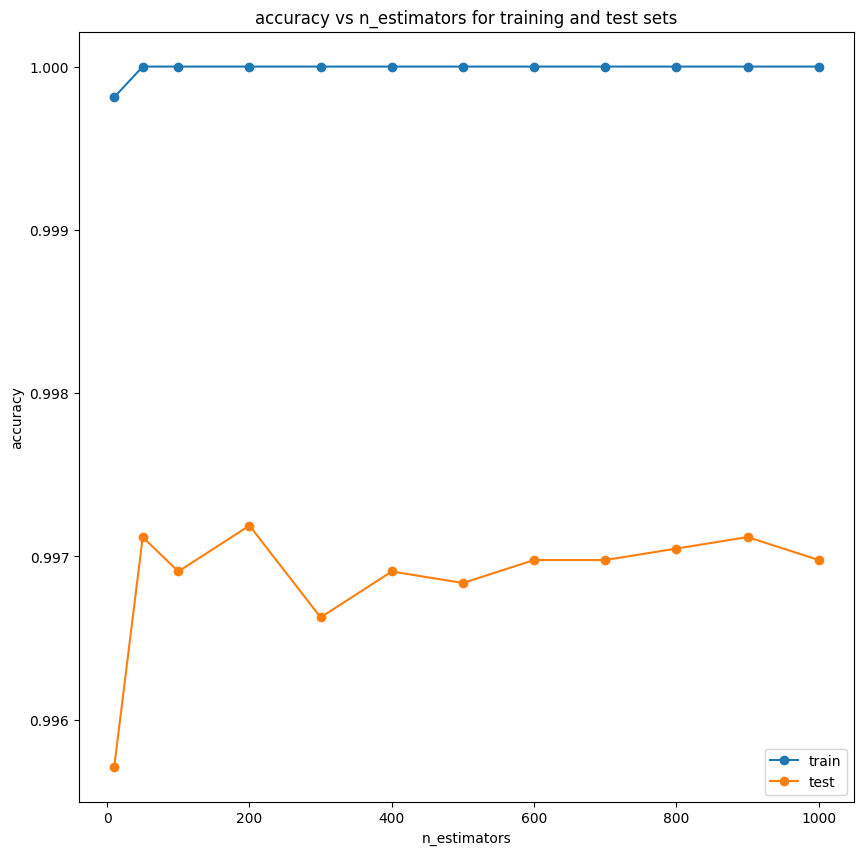

In [85]:
ns = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
train_accuracies = []
test_accuracies = []
for n in ns:
    clf = RandomForestClassifier(class_weight='balanced', n_estimators=n, n_jobs=-1).fit(X_train, y_train)
    test_accuracies.append(clf.score(X_test, y_test))
    train_accuracies.append(clf.score(X_train, y_train))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('n_estimators')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs n_estimators for training and test sets')
ax.plot(ns, train_accuracies, marker='o', label='train')
ax.plot(ns, test_accuracies, marker='o', label='test')
ax.legend()
plt.show()

Looking at the plot above there is no improvement in test accuracies when going beyond 50 estimators

### Conclusion and Summary

I started with a language classification problem for speech data. I looked at the kind of features you can extract from the audio signal especially the time and frequency domain signal data
and short-term fourier transform data which allows us to represent the audio signal in both time and frequency domains. I ended up choosing the mel frequency cepstral coefficients as my features
as they have proven to be very useful in separating components of human speech from other audio characteristics like pitch.

I started with a simple logistic regression model on the MFCCs as features and was able to get a very high accuracy of 96.64%. I tried decision tree classifiers and was able to get an even
more impressive result of 98.14% with a single tree. Applying a Random Forest classifier, the test accuracy got a further boost to 99.73%.

Considering that ensmeble models on DT classifiers were able to achieve such a good accuracy in distinguishing between two closely related languages,   
as further work I am tempted to train a multi-class classifiers that tries to accurately detect the language across multiple languages.